In [1]:
import numpy as np
import pandas as pd
import json

from astropy.io import fits

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

from astropy.visualization import make_lupton_rgb
plt.style.use('dark_background')

In [2]:
metadata = pd.read_csv('Metadata.csv')
subject_ids, my_ids = [], []

for (index, row) in metadata.iterrows():
    data_tmp = json.loads(row['subject_data'])[str(row['subject_ids'])]
    if(data_tmp['#CLASS'] != 'single_cand'): continue
    subject_ids.append(int(row['subject_ids']))
    my_ids.append(int(data_tmp['#NEW_ID']))

In [3]:
complete_metadata = pd.DataFrame()
complete_metadata['subject_id'] = subject_ids
complete_metadata['my_ids'] = my_ids

complete_metadata = complete_metadata.drop_duplicates()
print(len(complete_metadata))
complete_metadata.head()

869


,subject_id,my_ids
0,91739194,33
1,91739217,50
2,91739170,16
3,91739195,34
4,91739228,58


In [4]:
results = pd.read_csv('Beta_results.csv')

mask = complete_metadata['subject_id'].isin(results['subject_id'])
complete_metadata[mask]

key_data = complete_metadata.merge(results[['subject_id', 'score']], on='subject_id', how='left').dropna()
key_data = key_data.rename({'my_ids': '#NEW_ID'}, axis=1)
print(len(key_data))
key_data.head()

500


,subject_id,#NEW_ID,score
368,91832059,163,2.683516e-09
369,91832309,413,4.620815e-10
370,91832011,115,3.625979e-11
371,91831973,77,1.867044e-06
372,91832122,226,1.566882e-07


In [5]:
path = '/Users/jimenagonzalez/research/DSPL/SpaceWarps_Inspection/initial/for_test/'
hdu_list = fits.open(path + 'for_test.fits')
images = hdu_list[1].data
data = pd.DataFrame(hdu_list[2].data)
hdu_list.close()

data_mani = pd.read_csv(path + 'complete_not_manifest.csv')

data = data.merge(data_mani[['COADD_OBJECT_ID', '#NEW_ID', '#CLASS', '!REPORTED']], on='COADD_OBJECT_ID', how='left')
data = data.merge(key_data[['#NEW_ID', 'subject_id', 'score']], on='#NEW_ID', how='left')

new_data = data.sort_values(by='score', ascending=False)
images = images[new_data.index]
data = new_data

print(len(images), len(data))
data.head()

500 500


,COADD_OBJECT_ID,TILENAME,PROB,HPIX_16384,HPIX_4096,DNF_ZMEAN_SOF,RA,DEC,FLUX_RADIUS_G,FLUX_RADIUS_R,...,IMAFLAGS_ISO_G,IMAFLAGS_ISO_R,IMAFLAGS_ISO_I,IMAFLAGS_ISO_Z,EXT_COADD,#NEW_ID,#CLASS,!REPORTED,subject_id,score
435,1621099632,DES0206-4040,0.999855,2308734955,144295934,0.101100,31.271430,-40.641747,2.603267,2.409413,...,0,0,0,0,3,435,single_cand,True,91832331,1.000000
47,1179738251,DES0130-3749,0.999915,2332869597,145804349,0.634713,22.512071,-37.749394,8.201297,6.881944,...,0,0,0,0,3,47,single_cand,True,91831943,1.000000
86,1462052140,DES0411-5414,0.000000,2225717734,139107358,0.613226,62.800119,-54.221696,3.736405,3.568212,...,0,0,0,0,3,86,single_cand,True,91831982,1.000000
143,1466401262,DES0416-5457,0.999792,2225304471,139081529,0.600714,64.541216,-54.959696,7.852105,7.644029,...,0,0,0,0,3,143,single_cand,True,91832039,1.000000
227,1385113597,DES0323-5248,0.999882,2205683841,137855240,0.387395,50.568423,-52.577903,10.299603,7.857754,...,0,0,0,0,3,227,single_cand,True,91832123,0.999999


In [6]:
def make_plot_all(objects, title, data, Q, stretch, minimum):
    for i in range(len(objects)):
        if(i%7 == 0):
            plt.figure(figsize=(12,2))
            for j in range(7):
                if(i+j > len(objects)-1): break
                plt.subplot(1,7,j+1)
                expo = "{:e}".format(data['score'].iloc[i+j]).split('e')[1]
                reported = 'T' if data['!REPORTED'].iloc[i+j] else 'F'
                title = 'Scr: {}, {}'.format(expo, reported)
                plt.title(title)
                #print(data['COADD_OBJECT_ID'].iloc[i+j]) 
                rgb = make_lupton_rgb(objects[i+j][2], objects[i+j][1], objects[i+j][0], 
                                    Q=Q, stretch=stretch, minimum=minimum)
                plt.imshow(rgb, aspect='equal')
                plt.xticks([], [])
                plt.yticks([], []) 
            #plt.savefig(png_filepath + title + '.png', bbox_inches='tight')
        plt.show() 

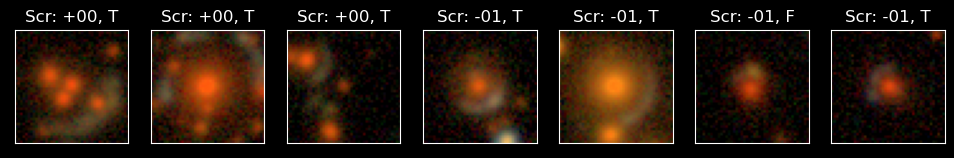

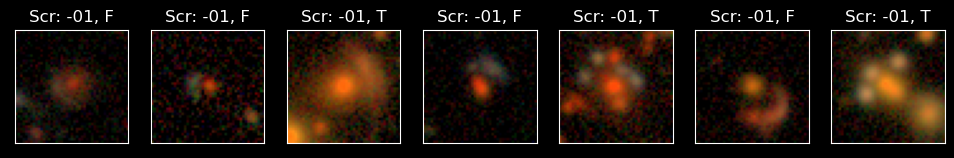

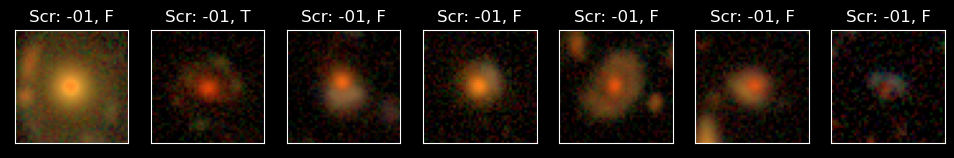

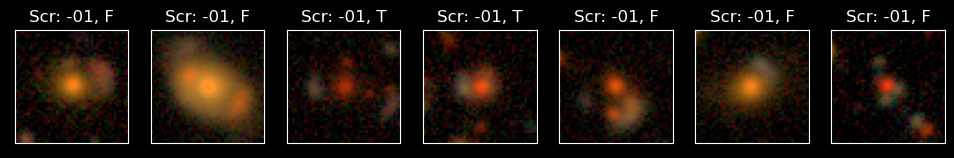

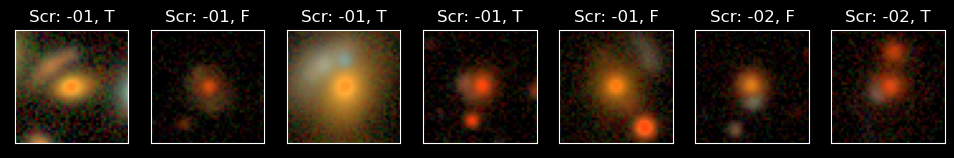

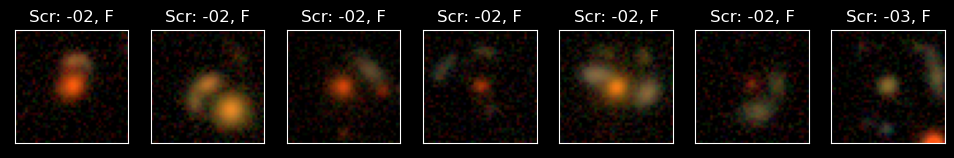

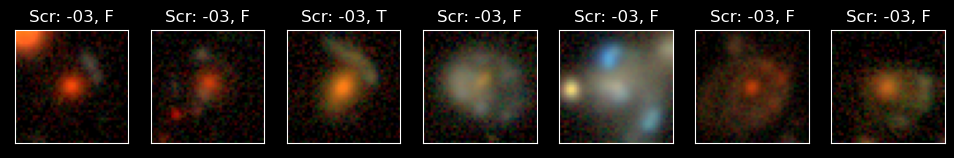

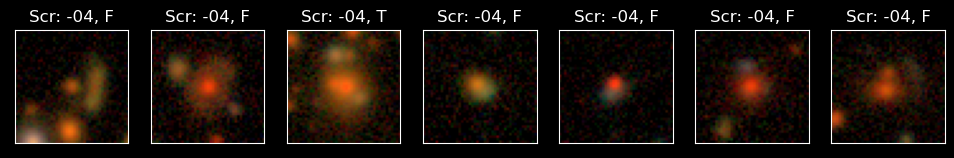

In [7]:
n = 56
make_plot_all(images[0:n], 'title', data.iloc[0:n], 9, 45, (0, 0, 0))

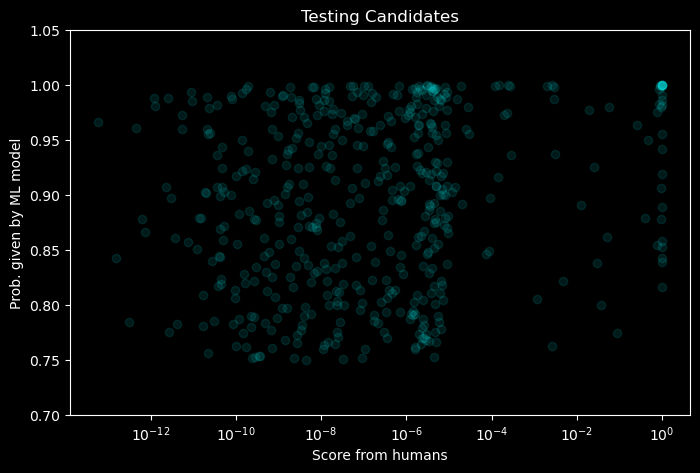

In [8]:
data.columns

plt.figure(figsize=(8,5)) 

plt.title('Testing Candidates')
plt.xlabel('Score from humans')
plt.ylabel('Prob. given by ML model')
plt.xscale("log")
plt.ylim(0.7, 1.05)
plt.scatter(data['score'], data['PROB'], color = 'cyan', alpha = 0.1)
#plt.plot(x, y, color='w')
plt.show()